### Word representation and clustering

In [1]:
import glob

import pandas as pd 

import matplotlib.pyplot as plt 

import torch

import numpy as np

from statistics import mode

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.cluster import contingency_matrix

from transformers import BertModel, BertForMaskedLM, BertTokenizer

from gensim.models import Word2Vec

#### Data set

The database consists of 1839 news taken from Kaggle data sets, 510 of them are related to business, 417 are related to politics, 511 are related to sports and 401 are related to tech.

In [2]:
data = []
labels = []
df = pd.DataFrame()
files = glob.glob('news/*.txt')

for file in files:
    with open(file, encoding='utf8', errors='ignore') as f:
        #get all the articles
        data.append(f.read())
        #extract the label
        file = file.strip('news/')
        labels.append(file[3:-4])
        
df['article'] = data
df['label'] = labels
df = df.sort_values('label')

articles = df.article
labels = df.label

df.head(10)

,article,label
0,ID theft surge hits US consumers\n\nAlmost a q...,business
873,Ex-Boeing director gets jail term\n\nAn ex-chi...,business
874,Markets fall on weak dollar fears\n\nRising oi...,business
877,Vodafone appoints new Japan boss\n\nVodafone h...,business
880,Singapore growth at 8.1% in 2004\n\nSingapore'...,business
881,UK interest rates held at 4.75%\n\nThe Bank of...,business
883,Yukos sues four firms for $20bn\n\nRussian oil...,business
886,Steady job growth continues in US\n\nThe US cr...,business
891,Russian oil merger excludes Yukos\n\nThe merge...,business
892,Shares rise on new Man Utd offer\n\nShares in ...,business


#### Articles representation with DTM

In [3]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(articles)
dtm_articles = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

print(dtm_articles.head())

   00  000  0001  000bn  000m  000s  001  001and  004  0051  ...  zombies  \
0   0    2     0      0     0     0    0       0    0     0  ...        0   
1   0    1     0      0     0     0    0       0    0     0  ...        0   
2   0    0     0      0     0     0    0       0    0     0  ...        0   
3   0    1     0      0     0     0    0       0    0     0  ...        0   
4   0    0     0      0     0     0    0       0    0     0  ...        0   

   zone  zonealarm  zones  zoom  zooms  zornotza  zuluaga  zurich  zvonareva  
0     0          0      0     0      0         0        0       0          0  
1     0          0      0     0      0         0        0       0          0  
2     0          0      0     0      0         0        0       0          0  
3     0          0      0     0      0         0        0       0          0  
4     0          0      0     0      0         0        0       0          0  

[5 rows x 25789 columns]


#### Pros : 
- Straightforward representation, each row $i$ corresponds to an article $i$ that we can access easily with : DTM_articles.iloc[$i$][:] 
- Very fast to compute, can be trained on personal machine

#### Cons :
- No real sense of similarity between words with this representation
- Extremely limited for NLP tasks

#### Article representation with TFIDF 

In [4]:
vec = TfidfVectorizer()
X = vec.fit_transform(articles)
tfidf_articles = pd.DataFrame(X.todense().tolist(), columns=vec.get_feature_names())

tfidf_articles.head()

,00,000,0001,000bn,000m,000s,001,001and,004,0051,...,zombies,zone,zonealarm,zones,zoom,zooms,zornotza,zuluaga,zurich,zvonareva
0,0.0,0.056311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.016114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.037910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Pros :
- Straightforward like the DTM, each row $i$ corresponds to the article $i$ than we can access with TFIDF_articles.iloc[$i$][:]
- Better weights

#### Cons :
- Do not capture the position of the words
- Limited for advanced NLP tasks that requires a good representation of the meaning

#### Article representation with Word2vec

Since Word2vec is a pre-trained model, we do not get the articles' word representations directly. For each word in an article, we have to retrieve its word representation from the model. We define a function to do that while taking care of the errors that can be raised if a word is missing from the model.

In [5]:
tokenized_articles = [article.split() for article in articles]
model_w2v = Word2Vec(tokenized_articles, min_count=1, window=5, size=100, sg=0)

def word2vec_embedding(tokenized_text):
    '''
    Description : 
        Returns a nested list of all the text's words embedding
    Args : 
        tokenized_text : any list of words
    '''
    zero = np.array([0]*100)
    full_text_vector = []
    for i in range(len(tokenized_text)):
        word = tokenized_text[i]
        try:
            full_text_vector.append(model_w2v.wv[word])
        except:
            full_text_vector.append(zero) #if a word is missing we replace its vector by zeros and we count the missing words
    return(full_text_vector)


def text_avg(tokenized_text):
    '''
    Description : 
        Returns an average of a text's words with Word2vec embedding
    Args : 
        tokenized_text : any list of words
    '''
    w2v = word2vec_embedding(tokenized_text) #we use the function we defined previously to represent the text with word2vec
    return(sum(w2v)/len(w2v))


X_w2v = []
for article in tokenized_articles:
    X_w2v.append(text_avg(article))

#### Pros : 
- Good sense of similarity between words
- Trains fast

#### Cons : 
- We cannot represent all the article's words with word2vec embedding because some words are missing from the vocabulary even though the model was trained on a 6 billion word corpus. Consequently, we lose a bit of the meaning of the articles.
- Context understanding is limited

#### Article representation with BERT

We will use the bert-base uncased Huggingface's implementation on PyTorch. There is a bigger model but this one is already very good for our purpose. This model is trained on 30000 words with 12 transformers and 768 weights for each vectors. In total, it needs to calculates 85 millions weights nearing 420 MB of memory space. Source: https://mccormickml.com/

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print(' Original: ', articles[0][:100])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(articles[0][:100]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(articles[0][:50])))

 Original:  ID theft surge hits US consumers

Almost a quarter of a million US consumers complained of being tar
Tokenized:  ['id', 'theft', 'surge', 'hits', 'us', 'consumers', 'almost', 'a', 'quarter', 'of', 'a', 'million', 'us', 'consumers', 'complained', 'of', 'being', 'tar']
Token IDs:  [8909, 11933, 12058, 4978, 2149, 10390, 2471, 1037, 4284]


Note : There are two hash symbols before some subwords in the tokenized version of the articles. According to Chris McCormick, it means that these subwords were already present in the vocabulary.

In [7]:
model = BertModel.from_pretrained('bert-base-uncased')

def avg_sentence_bert(text): 
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    token_vecs = encoded_layers[0]
    return(torch.mean(token_vecs, dim=0).tolist())


X_bert = []
for article in articles:
    # maximum number of words for the model is 512
    X_bert.append(avg_sentence_bert(article[:512])) 

#### Pros: 
- Context awareness
- No need to preprocess the text to use the model

#### Cons : 
- High computational cost, millions of parameters
- Not very good with domain specific language because of the lack of vocabulary
- Limited to 512 words per text

Now we can apply the clustering algorithms on all the articles representations

#### Kmeans with TFIDF representation

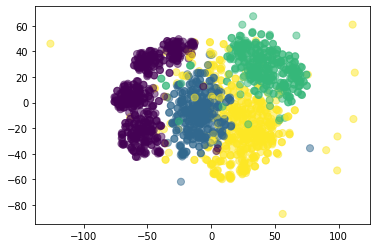

In [8]:
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(tfidf_articles)

kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(X_tfidf)
kmeans_predictions_tfidf = kmeans.labels_

model_tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model_tsne.fit_transform(X_tfidf)
plt.scatter(Y[:, 0], Y[:, 1], c=kmeans_predictions_tfidf, s=50,alpha=.5)

plt.show()

#### Kmeans with Word2vec embedding

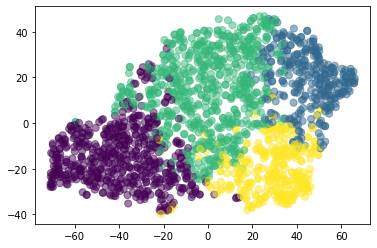

In [9]:
kmeans.fit(X_w2v)
kmeans_predictions_w2v = kmeans.labels_

model_tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y = model_tsne.fit_transform(X_w2v)
plt.scatter(Y[:, 0], Y[:, 1], c=kmeans_predictions_w2v, s=50,alpha=.5)

plt.show()

#### Kmeans with BERT embedding

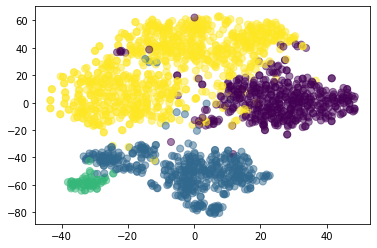

In [10]:
kmeans.fit(X_bert)
kmeans_predictions_bert = kmeans.labels_

model_tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model_tsne.fit_transform(X_bert)
plt.scatter(Y[:, 0], Y[:, 1], c=kmeans_predictions_bert, s=50,alpha=.5)

plt.show()

In [11]:
true_label = list(labels)
model_name = ['TF-IDF', 'Word2vec', 'BERT']
j = 0
predictions = [kmeans_predictions_tfidf, kmeans_predictions_w2v, kmeans_predictions_bert]

#mapping predicted and true labels
for preds in predictions:
    label_predict = list(preds)
    business_label = mode(label_predict[:510])
    politics_label = mode(label_predict[510:927])
    sport_label = mode(label_predict[927:1438])
    tech_label = mode(label_predict[1438:])
    
    for i in range(len(label_predict)):
        if label_predict[i] == business_label: label_predict[i] = 'business'
        elif label_predict[i] == politics_label: label_predict[i] = 'politics'
        elif label_predict[i] == sport_label: label_predict[i] = 'sport'
        else: label_predict[i] = 'tech'
    
    contingence_matrix = contingency_matrix(true_label, label_predict)
    print('='*5, model_name[j], '='*5, end='\n'*2)
    j += 1
    print(contingence_matrix, end='\n'*2)
    print('The accuracy of the model is {}'.format(round(accuracy_score(true_label, label_predict),2)),end='\n'*2)

===== TF-IDF =====

[[492   2   6  10]
 [ 36 374   3   4]
 [  9   0 502   0]
 [ 10   8   1 382]]

The accuracy of the model is 0.95

===== Word2vec =====

[[315  27   2 166]
 [ 35 202  62 118]
 [158  55 171 127]
 [ 51  13  79 258]]

The accuracy of the model is 0.51

===== BERT =====

[[476  29   5   0]
 [ 27 389   1   0]
 [  3   2 444  62]
 [385  13   3   0]]

The accuracy of the model is 0.71



### References

- Word2vec tutorial the skip-gram model - Chris McCormick
- Lecture Notes Stanford University School of Engineering : Natural language processing with deep learning (2017)